Import Packages

In [1]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import glob
import json
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from utils import score, visualize_result, storeData, readData, create_sequences, setSeed

pollutant = ['O3', 'CO', 'NO2', 'SO2', 'PM2.5', 'PM10']
environment = ['RH', 'AMB_TEMP']


sgx_sensor_dict = {'c1_4#ec_na#0': 'O3',
                   'c1_0#ec_na#0': 'CO',
                   'c1_3#ec_na#0': 'NO2',
                   'c1_5#ec_na#0': 'SO2'}

unit_table = {'O3': 'ppb', 
              'CO': 'ppm',
              'NO2': 'ppb',
              'SO2': 'ppb'}


2023

In [2]:
ref_data = pd.read_csv('data/reference.csv', index_col = [0])
ref_data.index = pd.to_datetime(ref_data.index)
ref_data

,REF-O3,REF-CO,REF-NO2,REF-SO2,REF-PM2.5,REF-PM10,REF-RH,REF-AMB_TEMP
2023-01-01 00:00:00,38.7,0.23,4.8,1.0,14.0,14.0,86.0,18.4
2023-01-01 01:00:00,38.3,0.22,5.3,0.4,9.0,13.0,87.0,18.6
2023-01-01 02:00:00,38.3,0.22,4.4,0.2,6.0,8.0,89.0,18.5
2023-01-01 03:00:00,38.3,0.21,4.1,0.1,8.0,3.0,88.0,18.6
2023-01-01 04:00:00,38.2,0.20,3.9,0.5,5.0,4.0,88.0,18.9
...,...,...,...,...,...,...,...,...
2023-04-24 06:00:00,24.1,0.32,11.5,0.5,26.0,55.0,94.0,22.1
2023-04-24 07:00:00,42.3,0.28,11.0,0.5,28.0,61.0,95.0,22.1
2023-04-24 08:00:00,36.8,0.38,13.1,0.3,28.0,69.0,94.0,22.3
2023-04-24 09:00:00,34.0,0.33,15.0,0.8,26.0,62.0,95.0,22.2


SGX

In [3]:
sgx_data = pd.read_csv('data/sgx.csv', index_col = [0])
sgx_data.index = pd.to_datetime(sgx_data.index)
sgx_data

,SGX-O3,SGX-CO,SGX-NO2,SGX-SO2
measure_time,,,,
2023-01-01 08:00:00,-1.539167,6.763333,28.492500,115.645333
2023-01-01 09:00:00,-0.052000,5.354000,35.532833,143.715667
2023-01-01 10:00:00,-0.260333,5.516667,41.556333,168.006500
2023-01-01 11:00:00,-0.130000,5.578000,44.988500,184.928333
2023-01-01 12:00:00,-0.469000,6.089000,45.418000,196.317667
...,...,...,...,...
2023-04-24 03:00:00,-0.403833,8.607667,19.882167,77.999000
2023-04-24 04:00:00,0.000000,6.879167,29.936500,78.948333
2023-04-24 05:00:00,-0.052000,7.107167,29.345833,78.634667


In [46]:
day_mask = (sgx_data.index.hour >= 8) & (sgx_data.index.hour < 23)
night_mask = ~day_mask
sgx_data_day = sgx_data.loc[day_mask]
sgx_data_night = sgx_data.loc[night_mask]

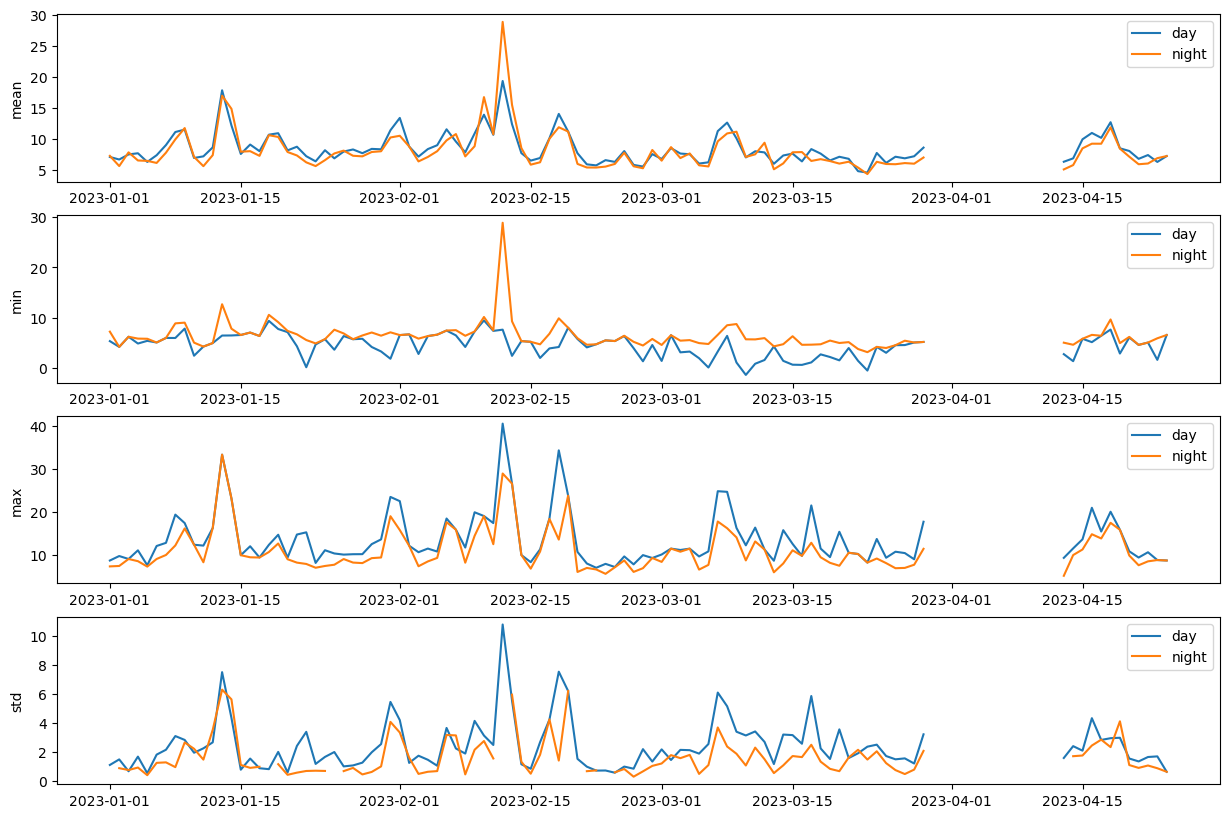

In [47]:
# assuming sgx_data is a DataFrame with a DatetimeIndex
day_data = sgx_data['SGX-CO'].groupby(sgx_data.index.date).agg(['mean', 'min', 'max', 'std'])
day_data.index = pd.to_datetime(day_data.index)

night_data = sgx_data_night['SGX-CO'].groupby(sgx_data_night.index.date).agg(['mean', 'min', 'max', 'std'])
night_data.index = pd.to_datetime(night_data.index)

# only keep the days where we have both day and night data
day_data = day_data.loc[day_data.index.isin(night_data.index), :]

# plot four subplots, one for each statistic
start_date = sgx_data.index.min().date()
end_date = sgx_data.index.max().date()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
day_data = day_data.reindex(date_range, fill_value=None)
night_data = night_data.reindex(date_range, fill_value=None)

fig, axes = plt.subplots(4, 1, figsize=(15, 10))

for i, stat in enumerate(['mean', 'min', 'max', 'std']):
    axes[i].plot(day_data.index, day_data[stat], label='day')
    axes[i].plot(night_data.index, night_data[stat], label='night')
    axes[i].set_ylabel(stat)
    axes[i].legend()

plt.show()


In [5]:
data = pd.concat([ref_data, sgx_data], axis = 1)
data = data.reindex(data.index, fill_value=np.nan)

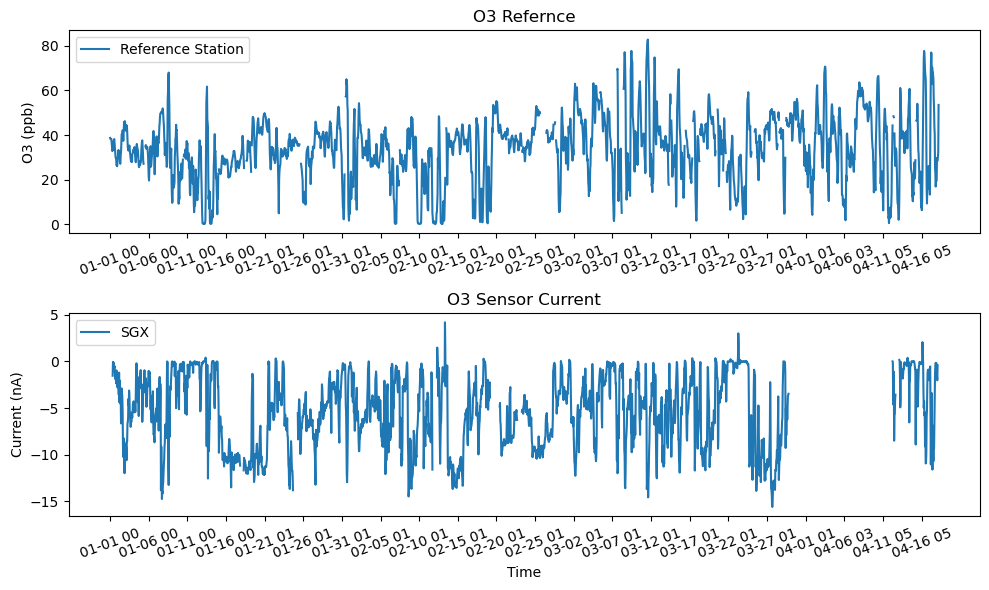

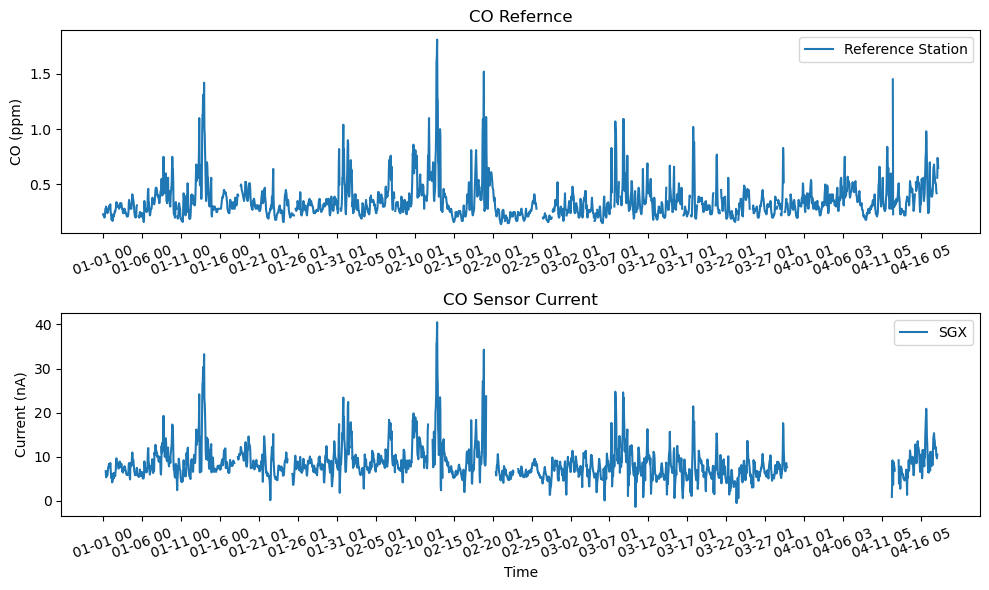

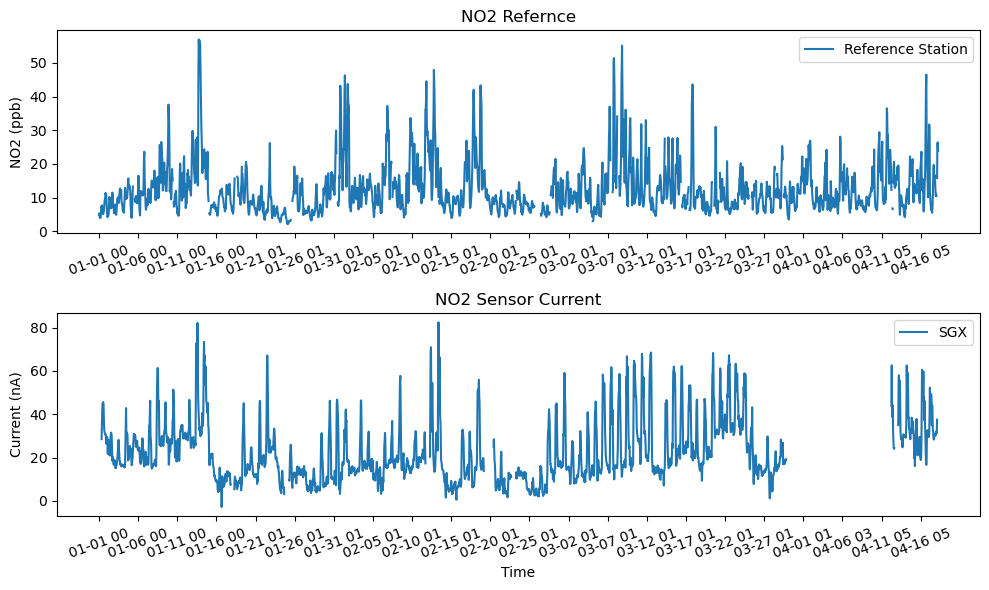

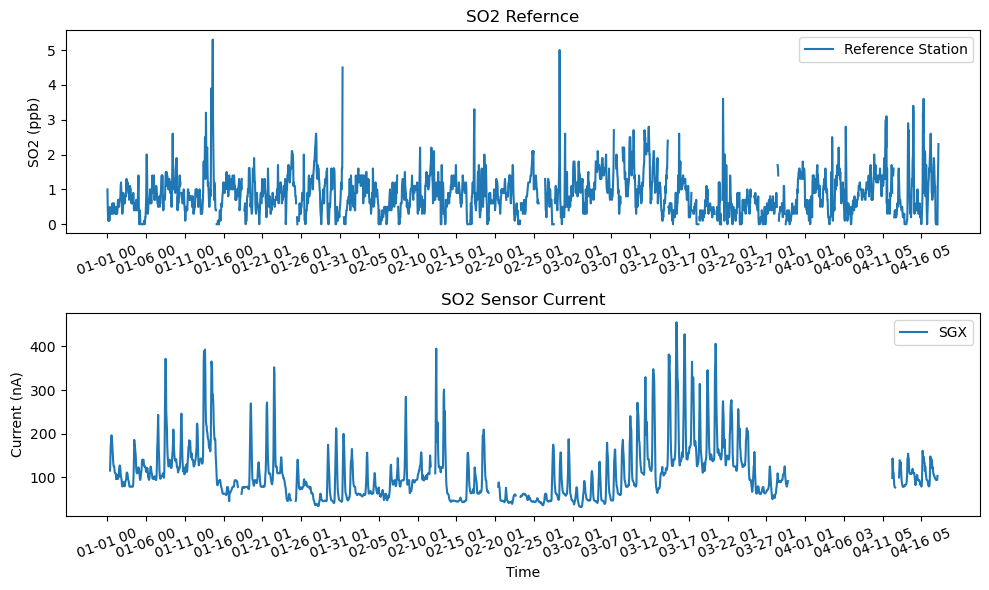

In [5]:
for gas in pollutant[:4]:
    labels = list(map(lambda x: str(x)[5:13], data.index[::120]))
    fig = plt.figure(figsize=(10, 6))

    ax1 = plt.subplot(211)
    ax1.set_title(f'{gas} Refernce')
    ax1.plot(data['REF-' + gas].values, label = 'Reference Station')
    ax1.legend()
    ax1.set_xticks(ticks = list(np.arange(0, len(data.index), 120)))
    ax1.set_xticklabels(labels = labels, rotation = 20)
    ax1.set_ylabel(f'{gas} ({unit_table[gas]})')
    

    ax2 = plt.subplot(212, sharex = ax1)
    ax2.set_title(f'{gas} Sensor Current')
    ax2.plot(data['SGX-' + gas].values, label = 'SGX')
    ax2.legend()
    ax2.set_xticks(ticks = list(np.arange(0, len(data.index), 120)))
    ax2.set_xticklabels(labels = labels, rotation = 20)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Current (nA)')

    plt.tight_layout()
    plt.savefig(f'fig/{gas}_comparison.png', dpi=300, bbox_inches='tight')


Correlation heatmap

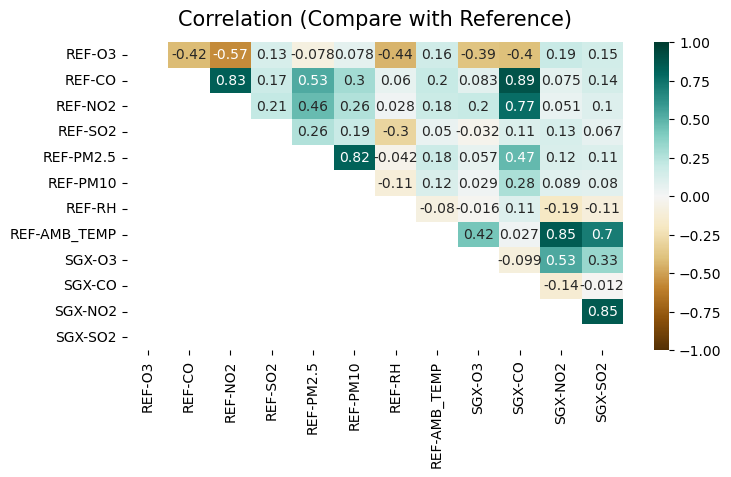

In [6]:
df = data.dropna().iloc[:, :12]
plt.figure(figsize=(8, 4))
# define the mask to set the values in the upper triangle to True
mask = np.tril(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG', mask=mask)
heatmap.set_title('Correlation (Compare with Reference)', fontdict={'fontsize':15}, pad=12)
plt.savefig('./fig/correlation_heatmap_outer.png', dpi=300, bbox_inches='tight')

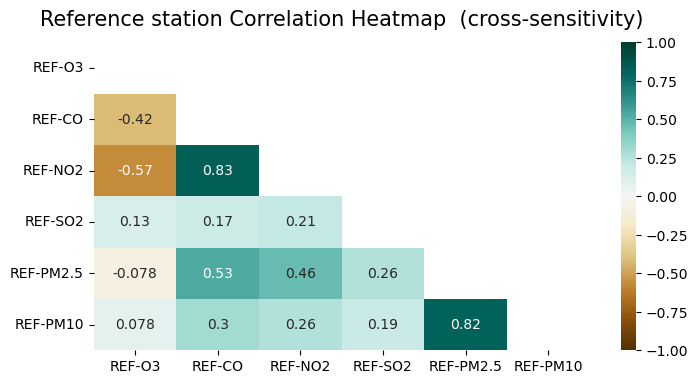

In [7]:
df = data.dropna().iloc[:, 0:6]
plt.figure(figsize=(8, 4))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Reference station Correlation Heatmap  (cross-sensitivity)', fontdict={'fontsize':15}, pad=12)
plt.savefig('./fig/ref_correlation_heatmap.png', dpi=300, bbox_inches='tight')

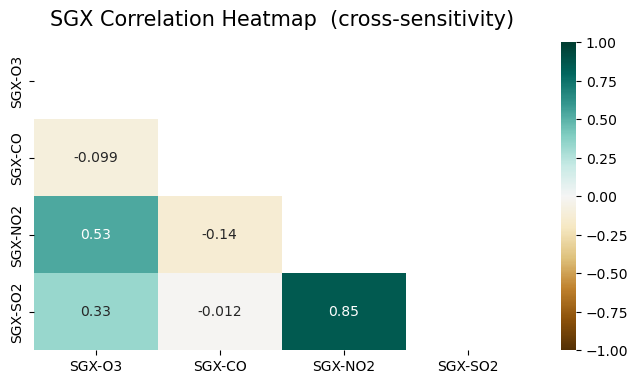

In [8]:
df = data.dropna().iloc[:, 8:12]
plt.figure(figsize=(8, 4))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('SGX Correlation Heatmap  (cross-sensitivity)', fontdict={'fontsize':15}, pad=12)
plt.savefig('./fig/sgx_correlation_heatmap.png', dpi=300, bbox_inches='tight')

Target Gas & Settings

In [6]:
gas = 'CO'

Sensor Drift #1

In [29]:
dates = sgx_data.loc[sgx_data.index.isin(ref_data.index), :].index
d = len(dates)
k = 8
# x = pd.concat([sgx_data.loc[dates, [f'SGX-{gas}']], ref_data.loc[dates, ['REF-AMB_TEMP', 'REF-RH']]], axis = 1).values
x = sgx_data.loc[dates, [f'SGX-{gas}']].values
y = ref_data.loc[dates, f'REF-{gas}'].values
print(x.shape, y.shape)

(2038, 1) (2038,)


Fold 1 R2: 0.861, RMSE: 0.040


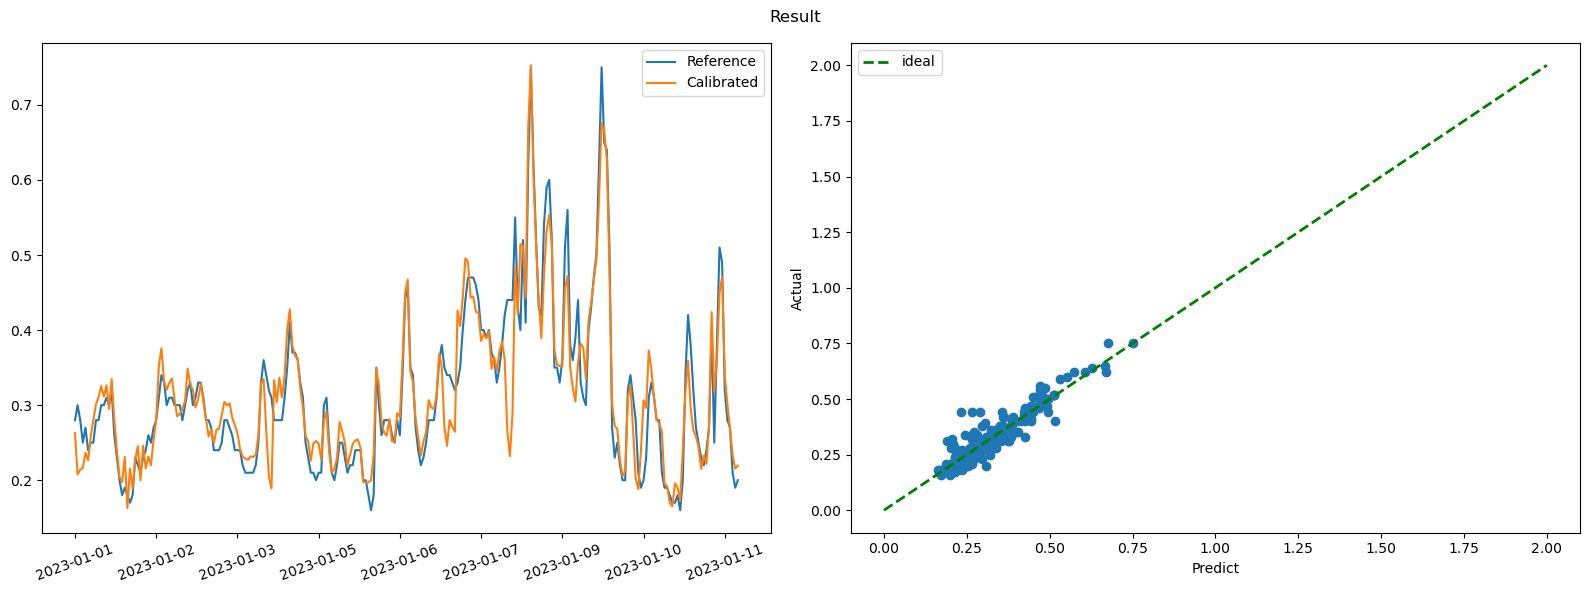

Fold 2 R2: 0.897, RMSE: 0.061


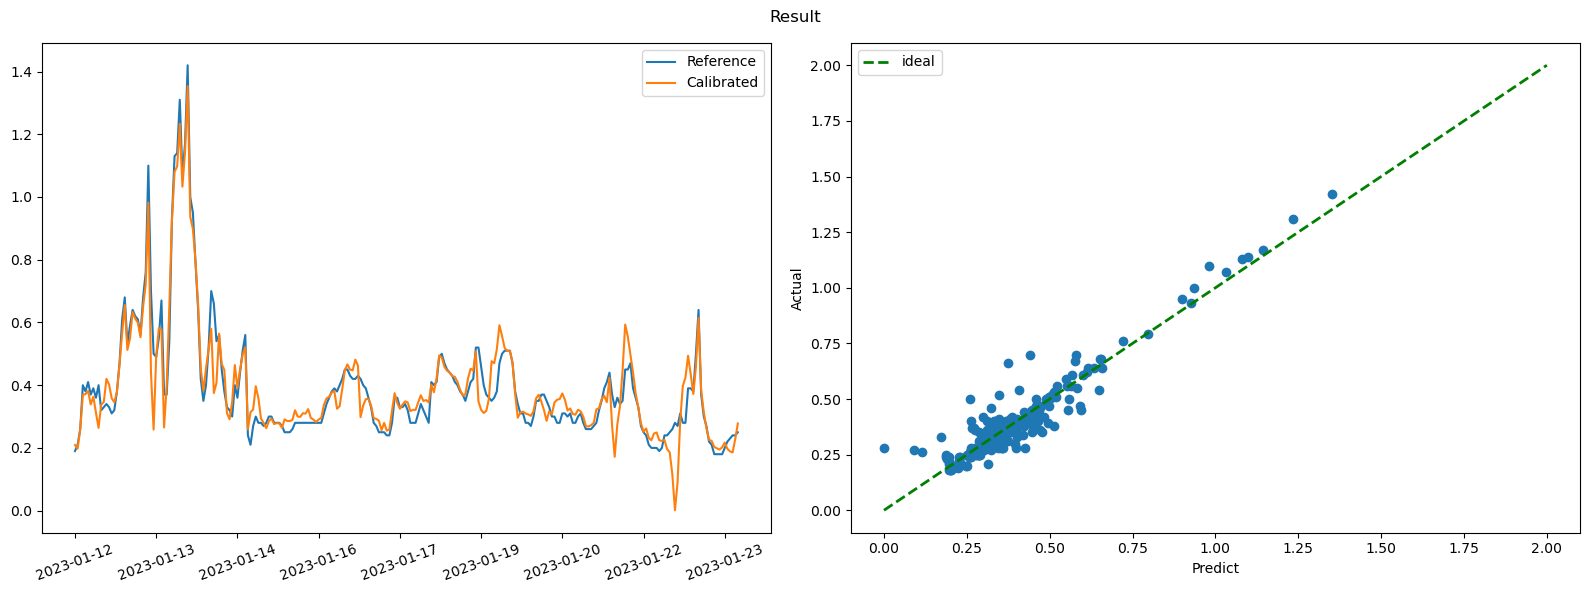

Fold 3 R2: 0.815, RMSE: 0.057


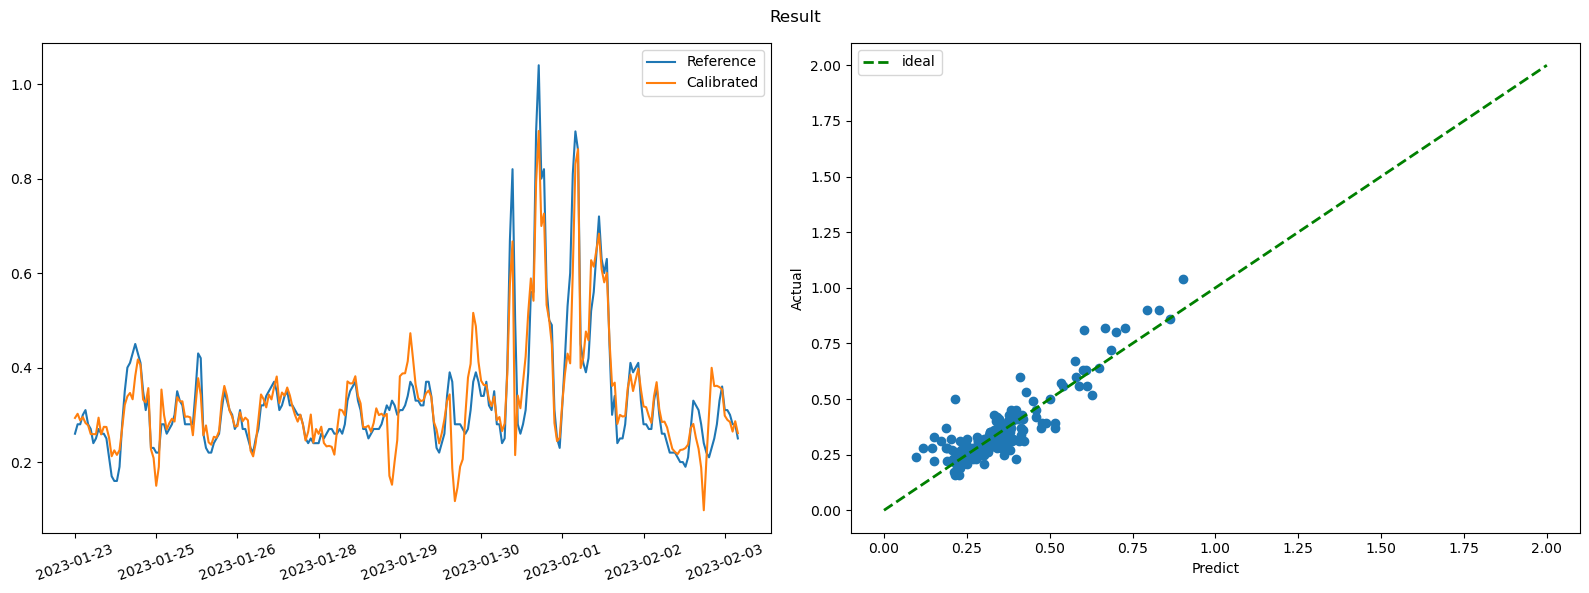

Fold 4 R2: 0.907, RMSE: 0.068


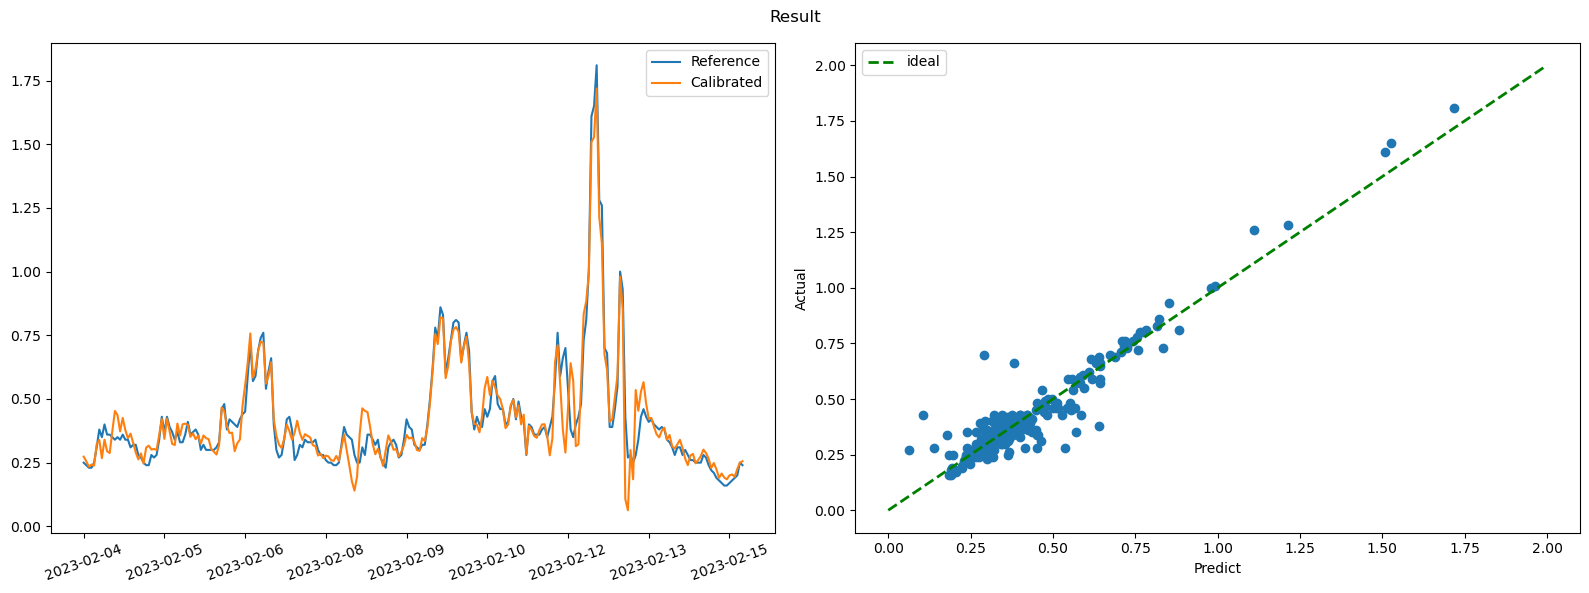

Fold 5 R2: 0.890, RMSE: 0.057


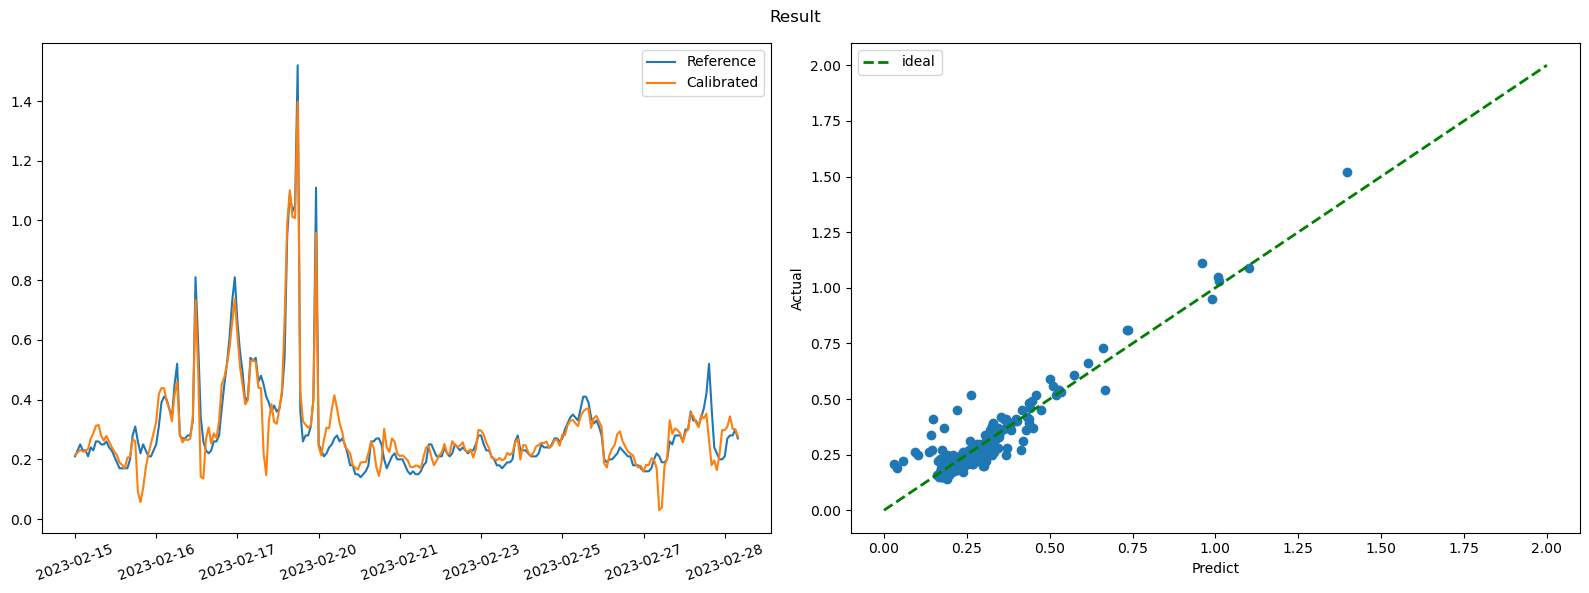

Fold 6 R2: 0.725, RMSE: 0.085


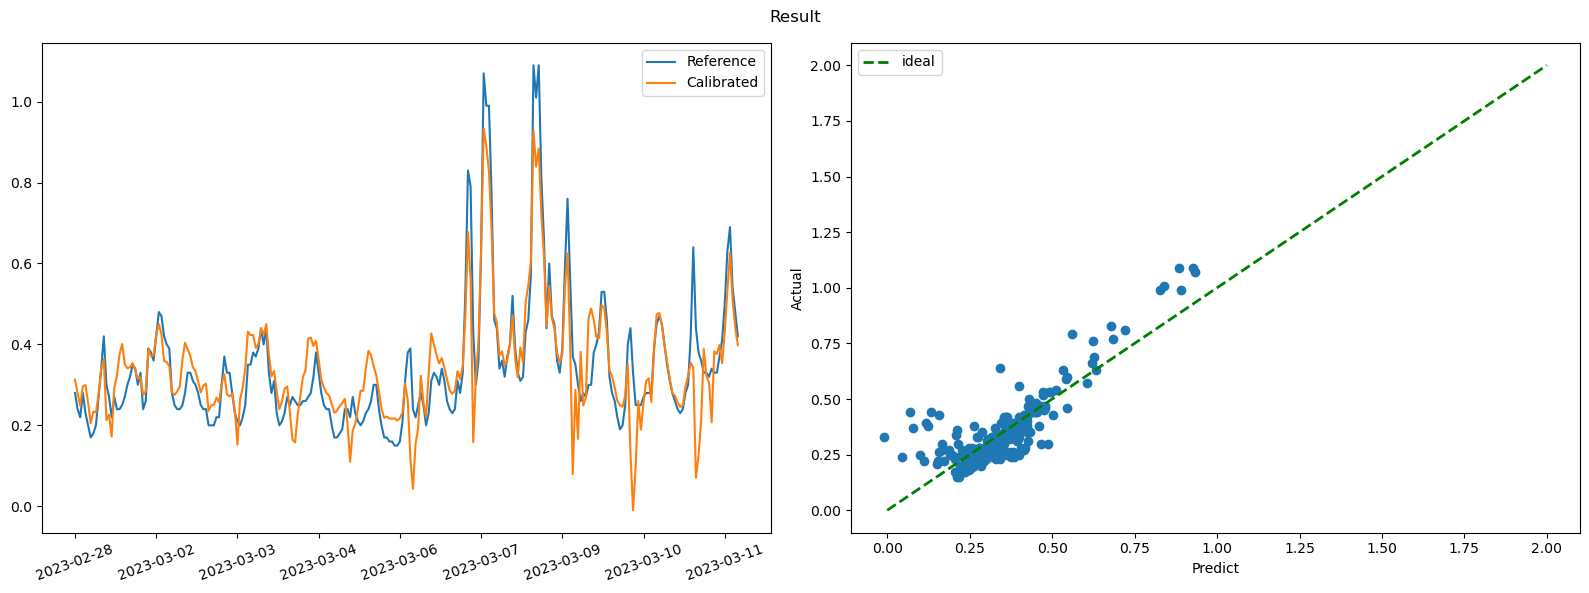

Fold 7 R2: 0.573, RMSE: 0.082


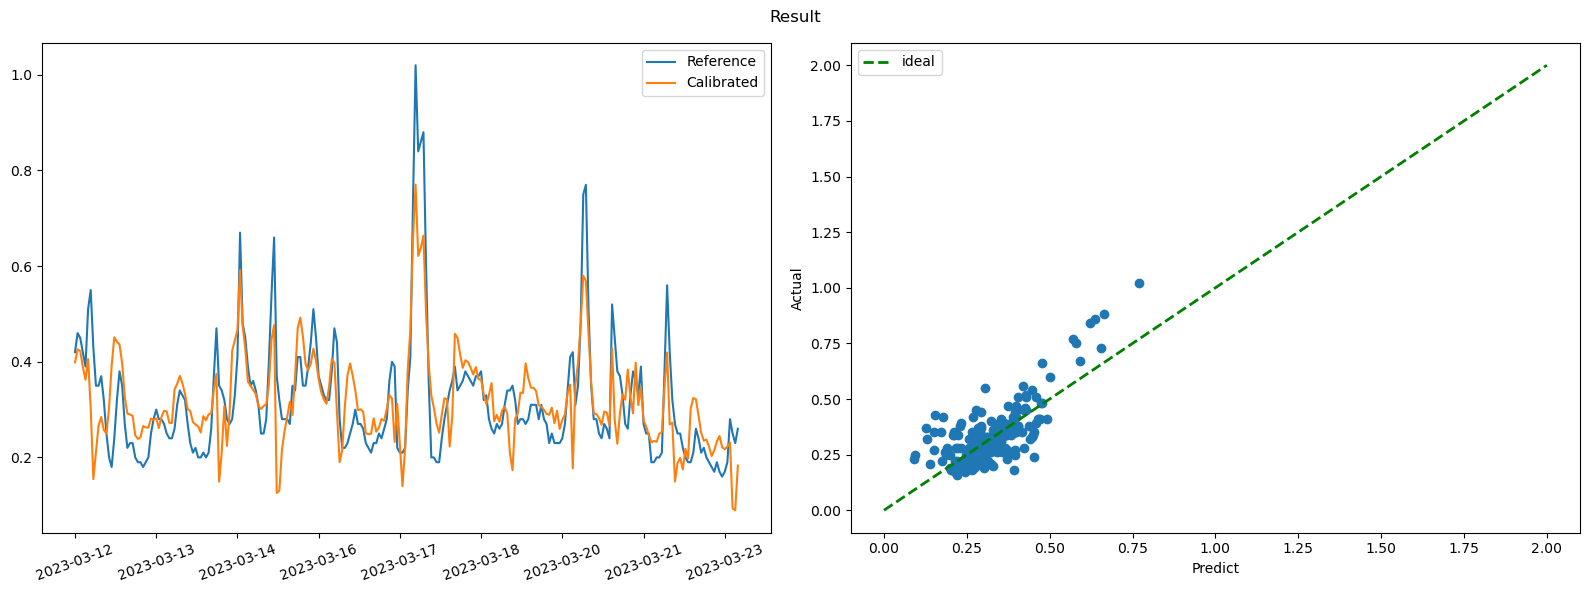

Fold 8 R2: 0.558, RMSE: 0.098


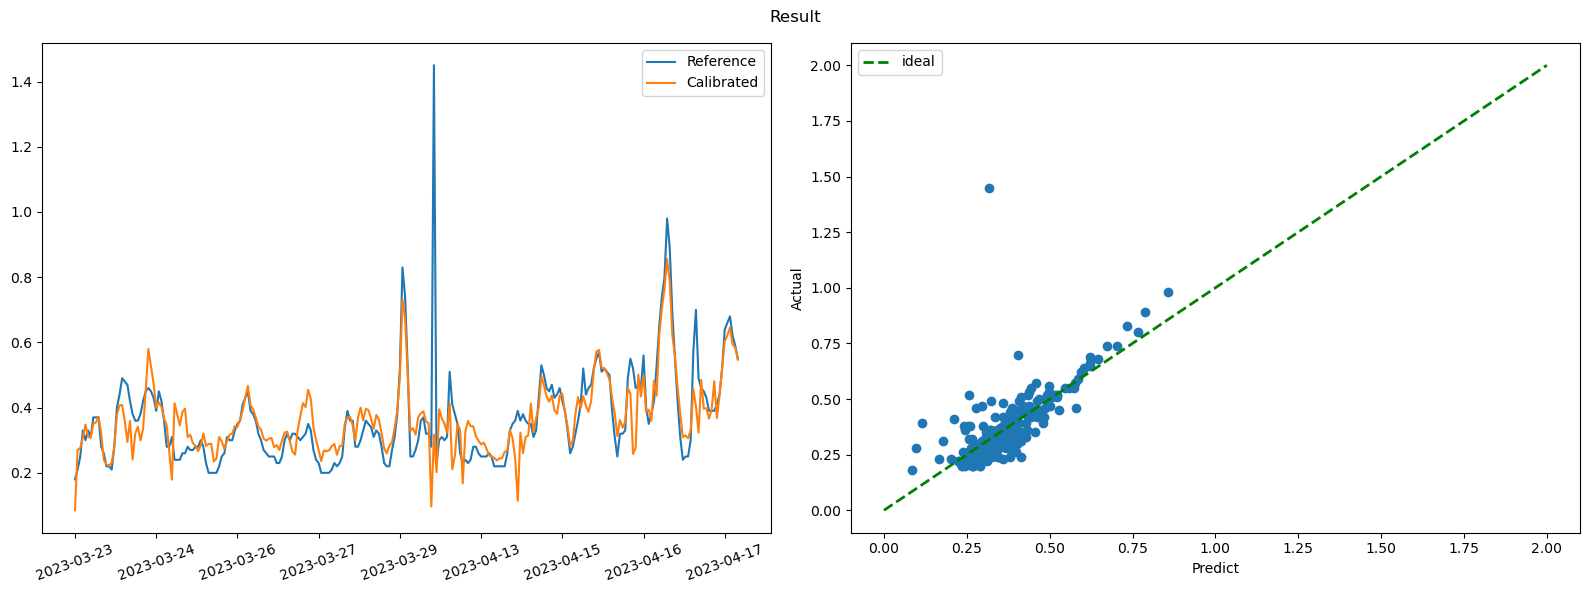

In [30]:
table_r2 = np.zeros((k, k))
table_rmse = np.zeros((k, k))
for t in range(k):
    x_train, y_train, dates_train = x[d//k*(t):d//k*(t+1)], y[d//k*(t):d//k*(t+1)], dates[d//k*(t):d//k*(t+1)]
    reg = LinearRegression().fit(x_train, y_train)
    # reg = SVR(kernel='rbf', C=1e3, gamma=0.1).fit(x_train, y_train)
    y_pred = reg.predict(x_train)
    table_r2[t, t] = r2_score(y_train, y_pred)
    table_rmse[t, t] = np.sqrt(mean_squared_error(y_train, y_pred))
    print(f'Fold {t+1} R2: {table_r2[t, t]:.3f}, RMSE: {table_rmse[t, t]:.3f}')
    visualize_result(y_train, y_pred, dates_train, title = '')
    for i in range(k):
        if i == t: continue
        x_test, y_test = x[d//k*(i):d//k*(i+1)], y[d//k*(i):d//k*(i+1)]
        y_pred = reg.predict(x_test)
        table_r2[t, i] = r2_score(y_test, y_pred)
        table_rmse[t, i] = np.sqrt(mean_squared_error(y_test, y_pred))

<AxesSubplot: >

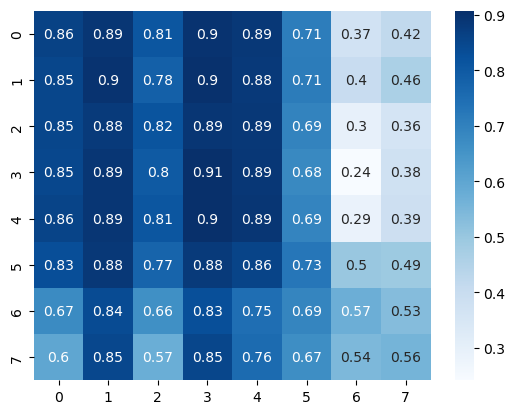

In [31]:
sns.heatmap(table_r2, annot=True, cmap='Blues')

<AxesSubplot: >

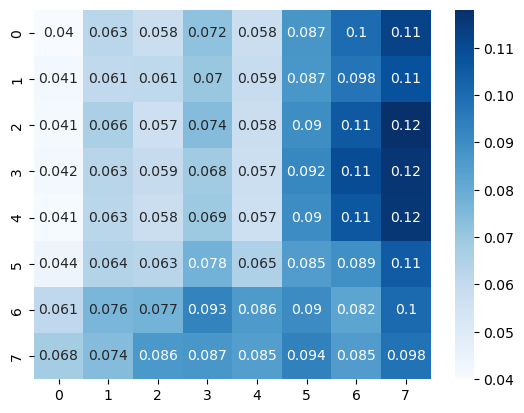

In [32]:
sns.heatmap(table_rmse, annot=True, cmap='Blues')

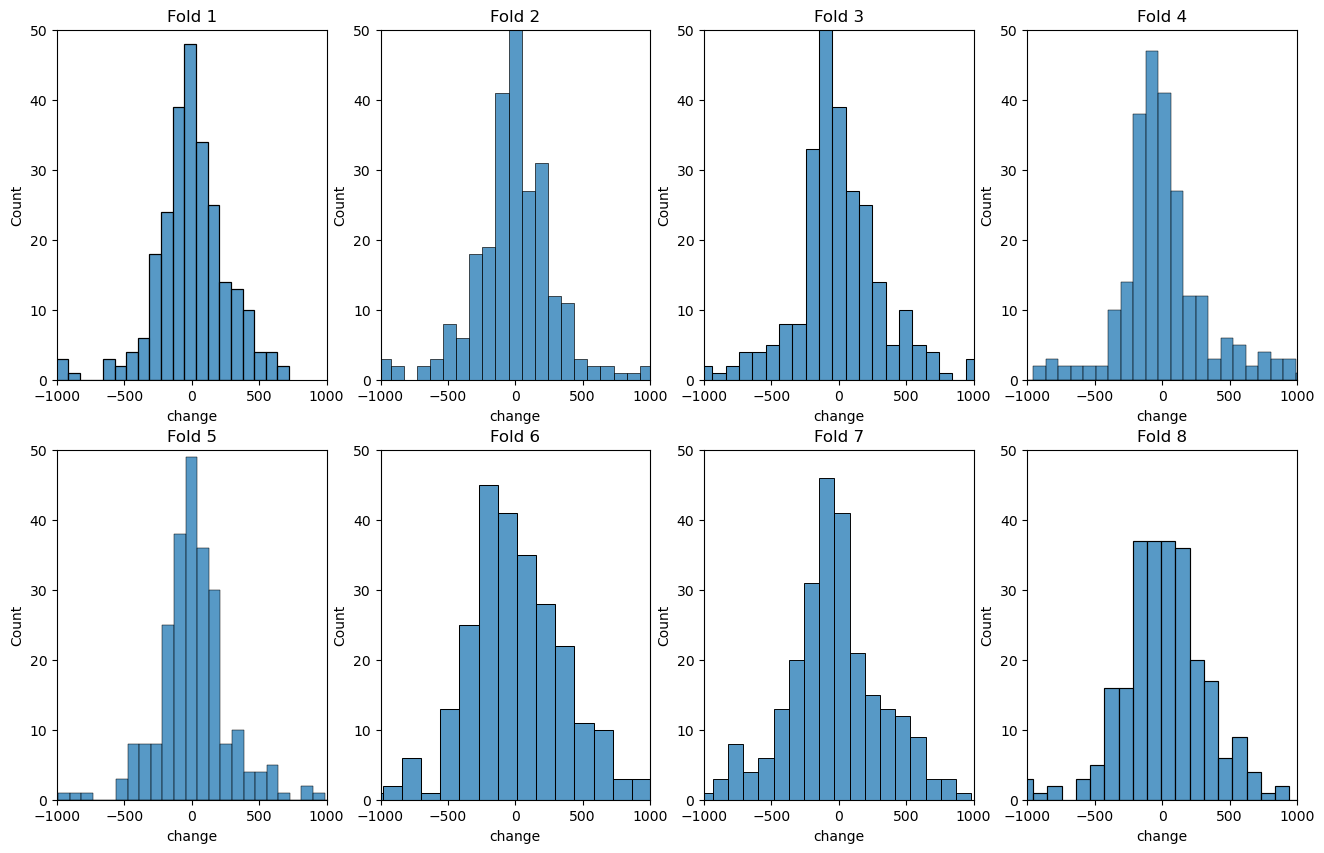

In [65]:
change = pd.DataFrame(x)[0]*100 -  pd.DataFrame(x)[0].shift(4)*100
change = change.fillna(0)
change = change.astype(int)
change.name = 'change'

fig, ax = plt.subplots(k//4, 4, figsize = (16, 10))

for i in range(k):
    sns.histplot(change[d//k*i:d//k*(i+1)], ax = ax[i//4, i%4]).set(title = f'Fold {i+1}', xlim = (-1000, 1000), ylim = (0, 50))

Sensor Drift #2

In [21]:
diff = x[:, 0] = y
group = [i // (len(dates)//k) for i in range(len(dates))]

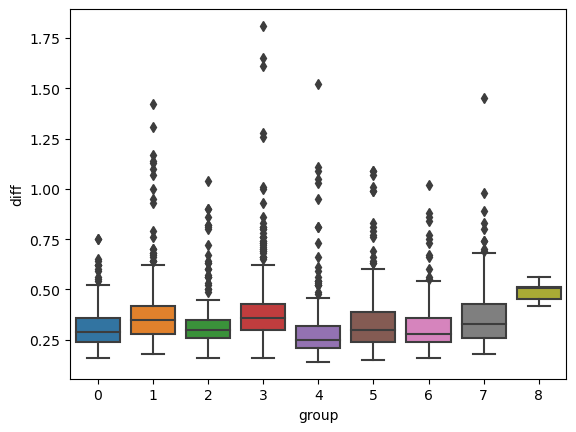

In [22]:
bp = pd.DataFrame({'diff': x[:, 0], 'group': group})
ax = sns.boxplot(x = 'group', y = 'diff', data = bp)

Sensor Drift #3